## TO DO LIST

* Nodes samen nemen
* Kortste route bepalen (inclusief wachttijd en overstaptijd)
* Andere prioriteiten: minste wachttijd en minste overstappen
* Voertuig logging verbeteren
* Overstap mogelijk maken
* Voertuig moet de juiste mensen meenemen

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data

In [2]:
# Import stations and lines from excel sheets
df1 = pd.read_csv("../../stations.csv")
df2 = pd.read_csv("../../lijnen.csv")

# Convert columns to lst type
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x))

In [3]:
df1.drop([2, 3, 4, 5])
df1

,Unnamed: 0,HalteNaam,HalteLat,HalteLon,Capacity,Line
0,0,Noord,52.401172,4.931232,100,metro52
1,1,Noorderpark,52.388555,4.917891,100,metro52
2,2,CentraalStation,52.377494,4.900781,100,metro52
3,3,Rokin,52.369280,4.892297,100,metro52
4,4,Vijzelgracht,52.359801,4.890729,100,metro52
5,5,DePijp,52.352962,4.891011,100,metro52
6,6,Europaplein,52.341855,4.891384,100,metro52
7,7,Zuid,52.339080,4.875099,100,metro52
8,8,CentraalStation,52.377720,4.901043,100,tram24
9,9,Dam,52.374929,4.895494,100,tram24


In [4]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [5]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

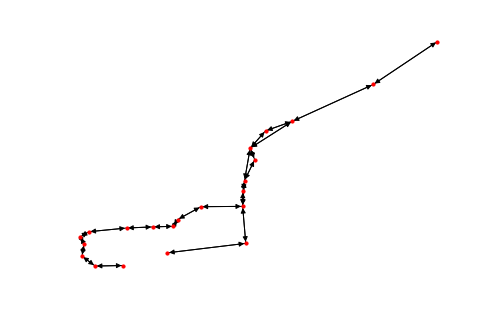

In [6]:
# Plot the network
nx.draw(FG, positions, node_size=10)
plt.show()

In [7]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["duration"] += (route_info["transfers"] * 2)
    return route_info

### Create moving parts

In [8]:
def generate_passenger(origin, destination, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
    
    # Travel direction
    route = nx.dijkstra_path(environment.FG, origin, destination, weight = 'duration')
    
    transfers = 1
    
    route_info = route_calculation(route, environment.FG)
    
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy()
                        })

In [9]:
def generate_metro(line, environment, linename):
    """ Generate a metro """
    Metro = type('Metro', (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})

    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Metro(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry})

### Spawn the metro trains

In [10]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60 * 60)
    while True:
        metro = generate_metro(lines[name][x], env, name)
        env.metros.append(metro)
        env.process(metro.move())
        
        # One metro every X minutes
        yield env.timeout(frequency * 60)

In [11]:
def passengers(env):
    yield env.timeout(5.5 * 60 * 60)
    while True:
        origin, destination = random.sample(env.FG.nodes, 2)

        passenger = generate_passenger(origin, destination, env)
        FG.nodes[origin]["object_type"].units.append(passenger)

        passenger.log_entry("Waiting for metro start", env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
        
        env.passengers.append(passenger)

        # Random arrivals of passengers with mean interarrival time of 30 seconds
        yield env.timeout(random.random() * 30)

### Run simulation

In [12]:
# Simulation start time
simulation_start = datetime.datetime(2019, 1, 1)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.metros = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 5.5, 6, "metro52", 0))
env.process(vehicle(env, 5.585, 6, "metro52", 1))
env.process(vehicle(env, 6, 10, "tram24", 0))
env.process(vehicle(env, 6, 10, "tram24", 1))
env.process(passengers(env))
env.run(until = env.now + 1 * 24 * 60 * 60)

TypeError: object.__init__() takes no parameters

### Check results

In [ ]:
# env.metros[17].log['Timestamp'][0].strftime ('%H:%M:%S')
for i in (env.metros[10].__dict__['log']['Geometry']):
    print(i)

In [ ]:
loglist = []
for i in range(len(env.passengers)):
    loglist.append(env.passengers[i].log['Message'])
    
print(len(loglist))
print(loglist.count(['Waiting for metro start']))
print(loglist.count(['Waiting for metro start','Waiting for metro stop','In metro start']))
print(loglist.count(['Waiting for metro start','Waiting for metro stop','In metro start', 'In metro stop']))

In [ ]:
# POINT (52.34169110000001 4.85773817)
env.passengers[0].__dict__

In [ ]:
passengerdf = pd.DataFrame.from_dict(env.passengers[50].log)
passengerdf

In [ ]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
        passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route, 
                                        "origin": env.passengers[i].route[0], 
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": 0, 
                                        "waiting_time": 0, 
                                        "modes": 0, 
                                        "transferindex": 0, 
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "class": 0, 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
passengerdf.to_csv("../../passengers.csv", index=True)

In [ ]:
env.metros[8].__dict__

In [ ]:
vehicledict = {}

for i in range(len(env.metros)):
    try:
        vehicledict[env.metros[i].id] = {"route": env.metros[i].route, 
                                        "mode": env.metros[i].name, 
                                        "departure": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("../../vehicles.csv", index=True)

In [ ]:
vehicledf